# Assignment 3

As before, if a question can be answered with 'yes/no', or a numeric value, you may simply state as much. If you incorporate code from the internet (which is not required and generally not advisable), please cite the source within your code (providing a URL is sufficient).

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that no outside searches are required by the assignment!). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

### Question 1: Resampling via Bootstrapping

Now, we'll use the `iris` dataset, which we will add to Python using the `statsmodels` library.

In [15]:
iris = sm.datasets.get_rdataset('iris', 'datasets')
df = pd.DataFrame(iris.data)

As usual, start by reviewing, describing and printing the dataset.

In [16]:
print(df.head())
print(df.shape)
print(df.describe())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
(150, 5)
       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


_(i)_ Create an `alpha_func(D, idx)` function which takes the `Sepal`'s `width` and `length` to calculate for alpha

In [17]:
def alpha_func(D, idx):    
    sepal_length = D['Sepal.Length'].iloc[idx]
    sepal_width = D['Sepal.Width'].iloc[idx]
    
    var_x = np.var(sepal_length, ddof=1)
    var_y = np.var(sepal_width, ddof=1)

    if var_x == 0 or var_y == 0:
        return np.nan

    cov_xy = np.cov(sepal_length, sepal_width, ddof=1)[0, 1]
    alpha = (var_y - cov_xy) / (var_x + var_y - 2 * cov_xy)
    
    return alpha

Test the code below

In [18]:
alpha_func(df, range(150))

0.24196097556885587

_(ii)_ Construct a new bootstrap data set and recompute alpha

In [19]:
warnings.filterwarnings("ignore")
rng = np.random.default_rng(0)
bootstrap_indices = rng.choice(df.index, size=150, replace=True)
bootstrap_alphas = [alpha_func(df, bootstrap_indices) for _ in range(150)]
bootstrap_alphas[:5]

[0.18830058535860075,
 0.18830058535860075,
 0.18830058535860075,
 0.18830058535860075,
 0.18830058535860075]

Imagine we are analysts working for a shipping company. The company wants to know the average length of iris' petals, to inform space allotment on an upcoming shipment. The relevant variable in the dataset is `Sepal.Length`. 

_(iii)_ Why is it (perhaps) not sufficient to simply calculate the mean of `Sepal.Length`?

- Calculating the mean of Sepal.Length gives us a single value that represents the average length of the sepals in the dataset.

What more information will preforming a bootstrap provide to us?

- The bootstrap method provides additional information about the reliability and precision of that mean by estimating the standard error.

_(iv)_ We can perform bootstrapping in Python by defining a simple function using `boot_SE()` for computing the bootstrap standard error. Remember, because bootstrapping involves randomness, we must first set a seed for reproducibility!

In [20]:
def boot_SE(data, column, n_bootstrap=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    bootstrap_means = [
        data[column].sample(frac=1, replace=True, random_state=rng).mean()
        for _ in range(n_bootstrap)
    ]
    
    bootstrap_se = np.std(bootstrap_means)
    return bootstrap_se

bootstrap_se = boot_SE(df, 'Sepal.Length')
print(f"Bootstrap standard error for Sepal.Length: {bootstrap_se}")

Bootstrap standard error for Sepal.Length: 0.06790599049012129


_(v)_ Evaluate the accuracy of our alpha estimate with B = 1000

In [21]:
def bootstrap_alpha(data, n_bootstrap=1000, seed=0):
    rng = np.random.default_rng(seed)
    bootstrap_alphas = []
    
    for _ in range(n_bootstrap):
        bootstrap_indices = rng.choice(data.index, size=len(data), replace=True)
        sepal_length_sample = data['Sepal.Length'].iloc[bootstrap_indices]
        sepal_width_sample = data['Sepal.Width'].iloc[bootstrap_indices]
        
        var_x = np.var(sepal_length_sample, ddof=1)
        var_y = np.var(sepal_width_sample, ddof=1)
        cov_xy = np.cov(sepal_length_sample, sepal_width_sample, ddof=1)[0, 1]
        
        if var_x == 0 or var_y == 0:
            bootstrap_alphas.append(np.nan)
        else:
            alpha = (var_y - cov_xy) / (var_x + var_y - 2 * cov_xy)
            bootstrap_alphas.append(alpha)
    
    mean_alpha = np.nanmean(bootstrap_alphas)
    se_alpha = np.nanstd(bootstrap_alphas)
    
    return bootstrap_alphas, mean_alpha, se_alpha


def bootstrap_means(data, column, n_bootstrap=1000, seed=0):
    rng = np.random.default_rng(seed)
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        bootstrap_sample = data[column].sample(frac=1, replace=True, random_state=rng)
        bootstrap_means.append(bootstrap_sample.mean())
    
    return bootstrap_means

bootstrap_alphas, mean_alpha, se_alpha = bootstrap_alpha(df, n_bootstrap=1000)
print(f"Mean alpha: {mean_alpha}")
print(f"Standard error of alpha: {se_alpha}")

Mean alpha: 0.24130919833797682
Standard error of alpha: 0.03180510076860766


_(vi)_ What is the original mean value of `Sepal.Length`?

In [22]:
original_mean_sepal_length = df['Sepal.Length'].mean()
print(f"Original mean of Sepal.Length: {original_mean_sepal_length}")

Original mean of Sepal.Length: 5.843333333333334



Next, let's look _inside_ our bootstrapping to understand the new, bootstrapped sample we have created. Let's review the bootstrapped range, by using `t_range = np.ptp(boot_se_samples)`.

_(vii)_. Write code to review the bootstrapped mean value, and the standard deviation of the bootstrapped samples. Compare the mean against its original value.

In [23]:
t_range = np.ptp(bootstrap_alphas)
print(f"Range of bootstrap alpha samples: {t_range}")

bootstrapped_mean_alpha = np.mean(bootstrap_alphas)
bootstrapped_std_alpha = np.std(bootstrap_alphas)
print(f"Bootstrapped mean alpha: {bootstrapped_mean_alpha}")
print(f"Bootstrapped standard deviation of alpha: {bootstrapped_std_alpha}")
print(f"Original mean of Sepal.Length: {original_mean_sepal_length}")

Range of bootstrap alpha samples: 0.20825385137700023
Bootstrapped mean alpha: 0.24130919833797682
Bootstrapped standard deviation of alpha: 0.03180510076860766
Original mean of Sepal.Length: 5.843333333333334


_(viii)_ Next, let's compute 95% confidence intervals, for the mean value of iris petal length. (Hint: use the `np.percentile` function)

In [24]:
bootstrap_samples = bootstrap_means (df, 'Sepal.Length', n_bootstrap=1000)

ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)
print(f"95% confidence interval for the mean Sepal.Length: ({ci_lower}, {ci_upper})")

95% confidence interval for the mean Sepal.Length: (5.718616666666667, 5.974716666666667)


_(ix)_. Use the plot function to create an histogram of the bootstrapped samples. What does this histogram show ?

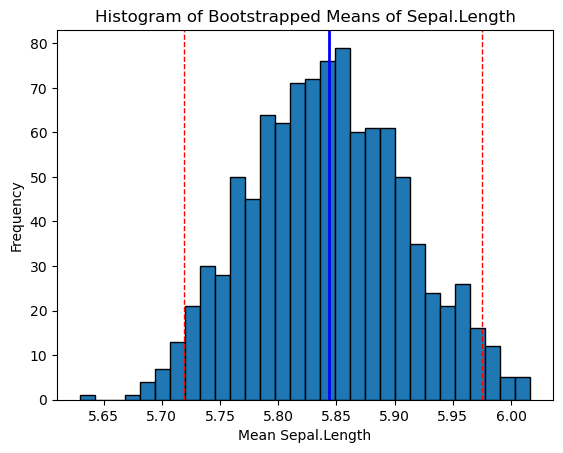

In [25]:
fig, ax = plt.subplots()

plt.hist(bootstrap_samples, bins=30, edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='dashed', linewidth=1)
plt.axvline(ci_upper, color='red', linestyle='dashed', linewidth=1)
plt.axvline(original_mean_sepal_length, color='blue', linestyle='solid', linewidth=2)

plt.title('Histogram of Bootstrapped Means of Sepal.Length')

plt.xlabel('Mean Sepal.Length')

plt.ylabel('Frequency')

plt.show()

_(x)_ Given your bootstrapped analysis, what do you recommend to shipping company? 

1. Calculate average petal space based on sepal length.
2. Leave extra space based on the highest limit of the 95% confidence range to accommodate petal differences and ensure all the petals can fit in the given area.
3. Regularly review space requirements with updated data and bootstrap analysis.

# Criteria

|Criteria            |Complete           |Incomplete          |
|--------------------|---------------|--------------|
|Bootstrapping|All steps are done correctly and the answers are correct.|At least one step is done incorrectly leading to a wrong answer.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.


### Submission Parameters:
* Submission Due Date: `11:59 PM - 16/06/2024`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/FredyLRincon/applying_statistical_concepts/pull/3`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
